In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy.integrate import odeint 
import ecos

In [123]:
def csf(state, C):
    return -1/2*((state[5]-0.138)**2 + state[6]**2) + C

def csf_de(state,C): 
    return C - (state[5] - 0.138)**2
    
    
def get_path(filename):
    return "../bags/" + filename + "/"+filename+".csv"
    
class ecos_data(): 
    def __init__(self, path, start=0): 
        self.data = pd.read_csv(path)
        self.start = start
        # Convert Strings to Arrays
        vector_keys = ['state_trueVec', 'state_measuredVec', 'input_actVec', 'input_desVec']
        for key in vector_keys:
            self.data[key] = self.data[key].str.replace('[','').str.replace(']','')
            self.data[key] = self.data[key].apply(np.fromstring, sep=', ')
            
    def evaluate_safety(self,C): 
        self.x5_true = []
        self.x6_true = []
        self.hs_true = []
        self.x5_meas = []
        self.x6_meas = []
        self.hs_meas = []
        self.C = C
        
        h = csf
        
        for state in self.data['state_trueVec']:
            self.x5_true.append(state[5]-0.138)
            self.x6_true.append(state[6])
            self.hs_true.append(h(state,C))
            
        for state in self.data['state_measuredVec']:
            self.x5_meas.append(state[5]-0.138)
            self.x6_meas.append(state[6])
            self.hs_meas.append(h(state,C))
        
        self.x5_true = np.array(self.x5_true)
        self.x6_true = np.array(self.x6_true)
        self.hs_true = np.array(self.hs_true)
        self.x5_meas = np.array(self.x5_meas)
        self.x6_meas = np.array(self.x6_meas)
        self.hs_meas = np.array(self.hs_meas)
            
    def plot_safety(self, bounds):
        x6_surf = np.outer(np.linspace(bounds[0]-1, bounds[1]+1,50), np.ones(50))
        x5_surf = x6_surf.copy().T-0.138
        hs_surf = -1/2*(x5_surf**2 + x6_surf**2) + self.C

        fig = plt.figure()
        ax = fig.gca()
        plt.plot(self.x5_true[self.start :],self.x6_true[self.start :], 'k')
        plt.plot(self.x5_meas[self.start :],self.x6_meas[self.start :], 'r--')
        safeSet = plt.Circle((0, 0), np.sqrt(self.C), color='g')
        ax.add_artist(safeSet)
        #plt.contour(x5_surf, x6_surf, hs_surf, [0], 'y')
        #for i in range(0, len(x5)-1, 10): 
        #    plt.arrow(x5[i], x6[i], x5[i+1] - x5[i], x6[i+1]-x6[i], shape='full', lw = 0, length_includes_head=True, head_width=0.2)
        plt.xlabel('theta_y - theta_y*')
        plt.ylabel('theta_dot_y')
        plt.xlim(bounds)
        plt.ylim(bounds)
        plt.title("State Space")
        plt.legend(['True', 'Meas', 'Safe Set'])
        plt.show()
            
        plt.figure()
        plt.plot(self.hs_true[self.start :], 'k')
        plt.plot(self.hs_meas[self.start :], 'r--')
        plt.plot(np.zeros(len(self.hs_meas)), 'g')
        plt.ylabel("h(x)")
        plt.xlabel("sample")
        plt.title("Safety Function")
        plt.legend(['True', 'Meas', "safe Set Boundary"])
        
    def plot_inputs(self, umax):
        self.u_act =[]
        for row in self.data['input_actVec']: 
            row = [ umax if r>umax else -umax if r<-umax else r for r in row]
            self.u_act.append(row)
        self.u_act = np.array(self.u_act)
                
        self.u_des =[]
        for row in self.data['input_desVec']: 
            self.u_des.append(row.tolist())
        self.u_des = np.array(self.u_des)
        
        fig, ax = plt.subplots(2,1)
        fig.suptitle('Inputs')
        ax[0].plot(self.u_act[self.start :,0], 'k')
        ax[0].plot(self.u_des[self.start :,0], 'r--')
        ax[0].legend(['Actual Input', 'Desired Input'])
        
        ax[1].plot(np.abs(self.u_act[self.start :,1]- self.u_des[self.start :,1]))
        ax[1].legend(["||Actual - Desired Input||"])
        plt.show()
        
    def plot_states(self): 
        fig, ax = plt.subplots(2,1)
        fig.suptitle('States')
        ax[0].plot(self.x5_true[self.start :], 'k')
        ax[0].plot(self.x5_meas[self.start :], 'r--')
        ax[0].legend(['True State', 'Measured State'])
        
        ax[1].plot(self.x6_true[self.start :], 'k')
        ax[1].plot(self.x6_meas[self.start :], 'r--')
        ax[1].legend(['True State', "Measured State"])
        plt.show()

        
        
class ecos_data_de(ecos_data):
    
    def evaluate_safety(self,C): 
        self.x5_true = []
        self.x6_true = []
        self.hs_true = []
        self.x5_meas = []
        self.x6_meas = []
        self.hs_meas = []
        self.C = C
        
        h = csf_de
        
        for state in self.data['state_trueVec']:
            self.x5_true.append(state[5]-0.138)
            self.x6_true.append(state[6])
            self.hs_true.append(h(state,C))
            
        for state in self.data['state_measuredVec']:
            self.x5_meas.append(state[5]-0.138)
            self.x6_meas.append(state[6])
            self.hs_meas.append(h(state,C))
        
        self.x5_true = np.array(self.x5_true)
        self.x6_true = np.array(self.x6_true)
        self.hs_true = np.array(self.hs_true)
        self.x5_meas = np.array(self.x5_meas)
        self.x6_meas = np.array(self.x6_meas)
        self.hs_meas = np.array(self.hs_meas)
        
    def plot_safety(self, xBounds, yBounds):
        fig = plt.figure()
        ax = fig.gca()
        plt.plot(self.x5_true[self.start :],self.x6_true[self.start :], 'k')
        plt.plot(self.x5_meas[self.start :],self.x6_meas[self.start :], 'r--')
        safeSet = plt.Rectangle((-np.sqrt(self.C), yBounds[0]), 2*np.sqrt(self.C), yBounds[1] - yBounds[0], angle=0, color='g')
        ax.add_artist(safeSet)
        #plt.contour(x5_surf, x6_surf, hs_surf, [0], 'y')
        #for i in range(0, len(x5)-1, 10): 
        #    plt.arrow(x5[i], x6[i], x5[i+1] - x5[i], x6[i+1]-x6[i], shape='full', lw = 0, length_includes_head=True, head_width=0.2)
        plt.xlabel('theta_y - theta_y*')
        plt.ylabel('theta_dot_y')
        plt.xlim(xBounds)
        plt.ylim(yBounds)
        plt.title("State Space")
        plt.legend(['True', 'Meas', 'Safe Set'])
        plt.show()
            
        plt.figure()
        plt.plot(self.hs_true[self.start :], 'k')
        plt.plot(self.hs_meas[self.start :], 'r--')
        plt.plot(np.zeros(len(self.hs_meas)), 'g')
        plt.ylabel("h(x)")
        plt.xlabel("sample")
        plt.title("Safety Function")
        plt.legend(['True', 'Meas', "safe Set Boundary"])

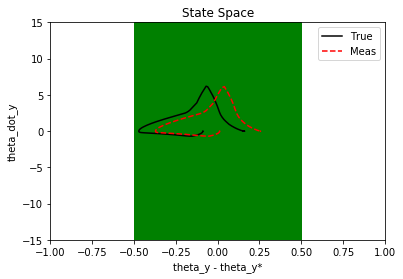

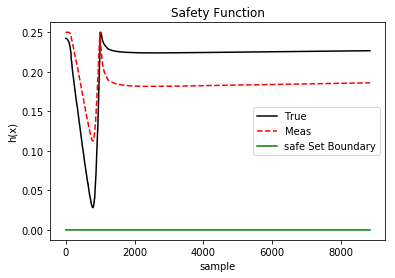

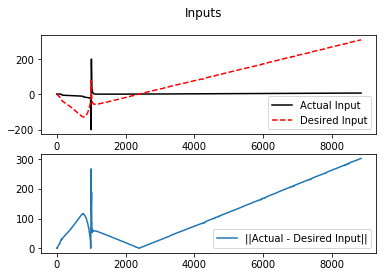

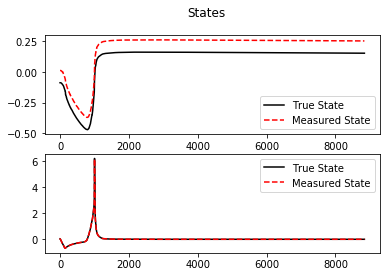

In [166]:
### For all the new DE's
# IC = [0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0]
# Gains =[0., 0., 0., 50.8129, 0., 147.1530, 46.8037]
# Safety Params: alpha=10, alpha_e = 1, L_Lfh = 3.5, L_Lgh = 0.1, L_ah = 5, C = 0.25, epsilon = 0.1

path = get_path("de_x5_plus01")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()


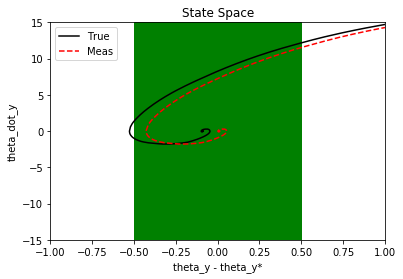

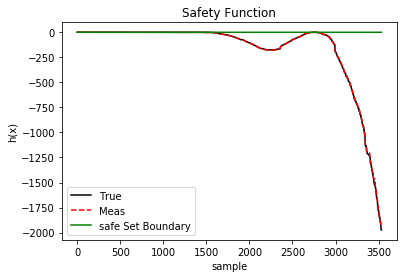

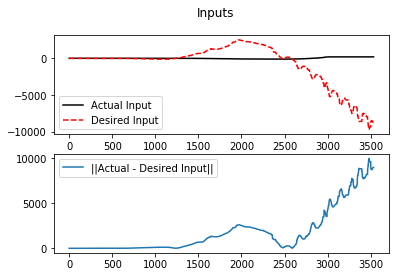

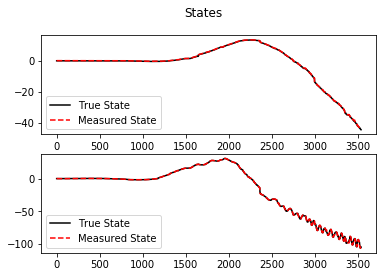

In [163]:
path = get_path("de_x5_plus01_noFilter")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()


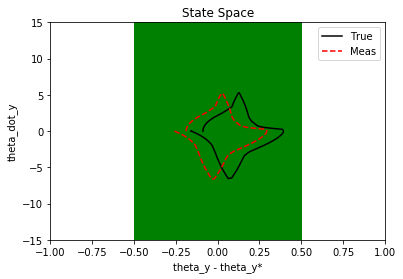

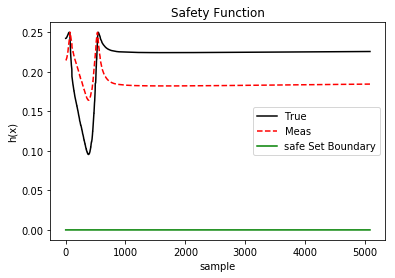

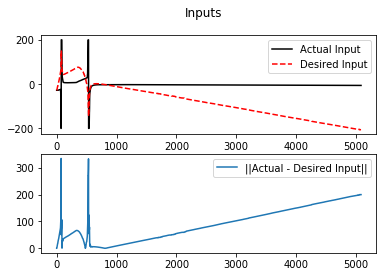

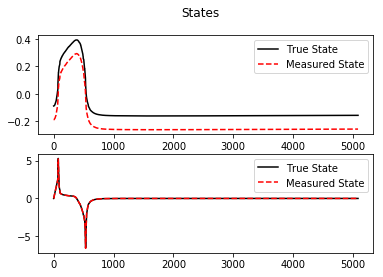

In [164]:
path = get_path("de_x5_minus01")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()

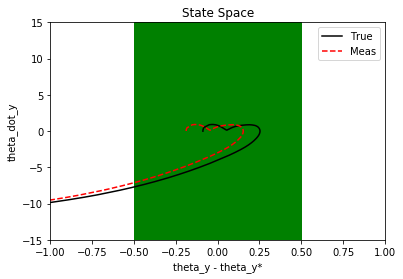

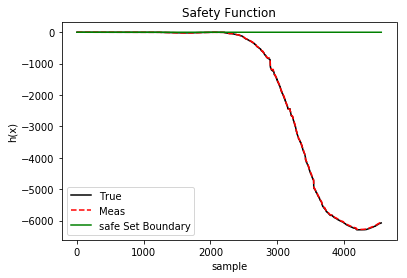

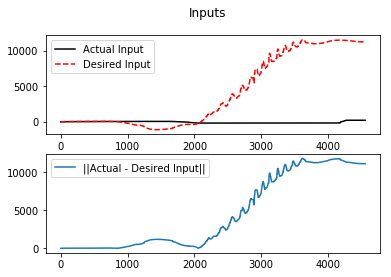

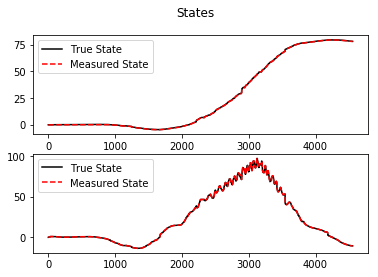

In [165]:
path = get_path("de_x5_minus01_noFilter")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()

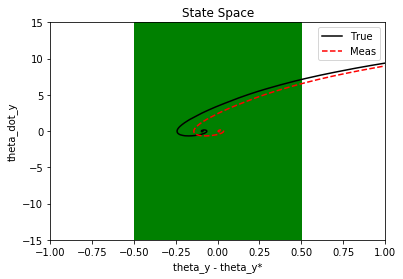

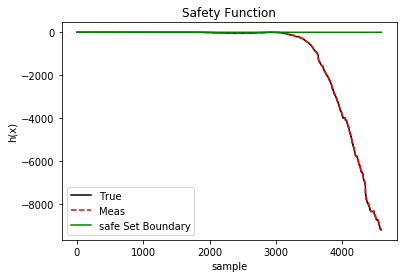

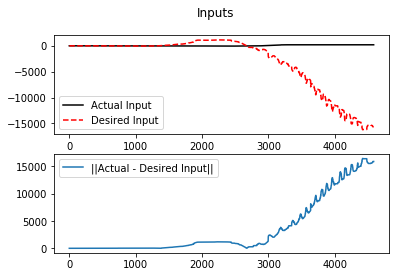

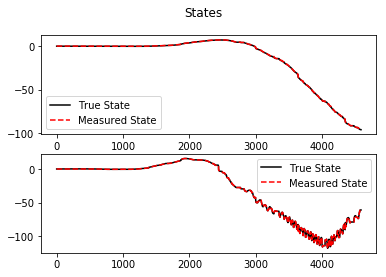

In [145]:
path = get_path("de12_noFilter")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()

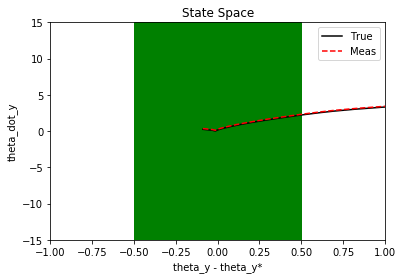

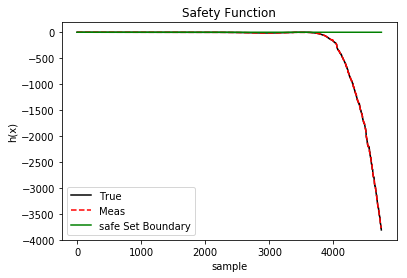

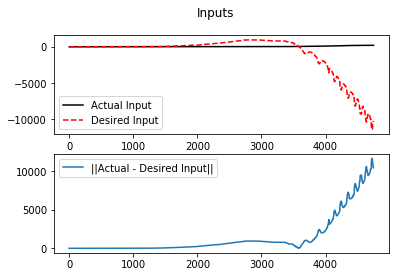

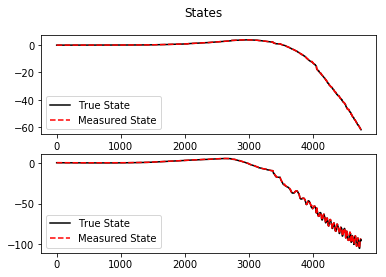

In [146]:
path = get_path("de13_noFilter")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()

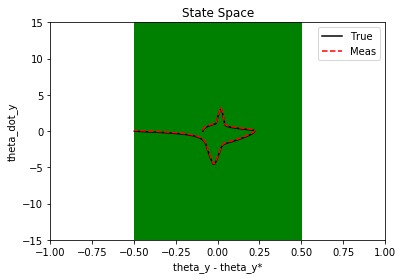

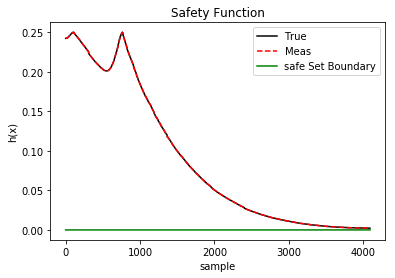

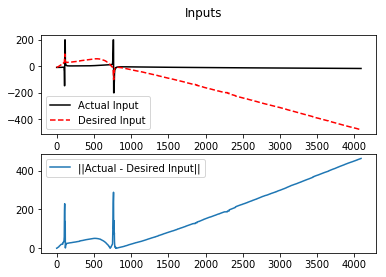

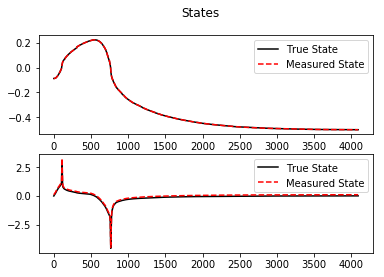

In [154]:
path = get_path("de13")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()

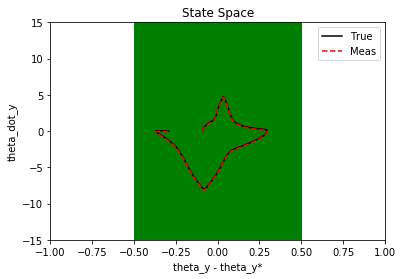

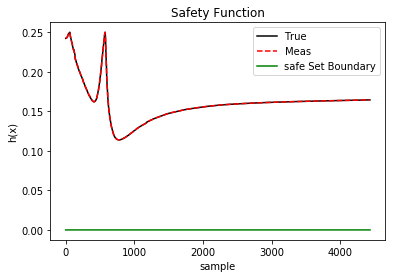

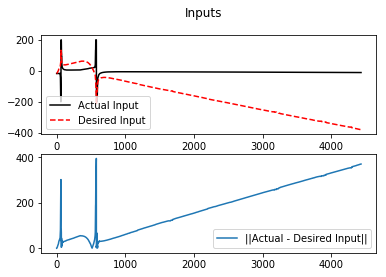

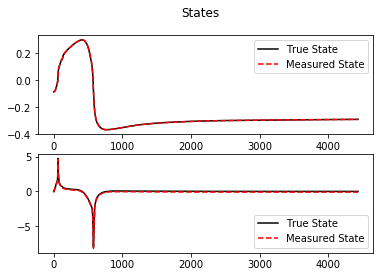

In [161]:
path = get_path("de14")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()

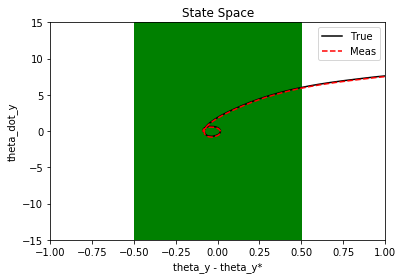

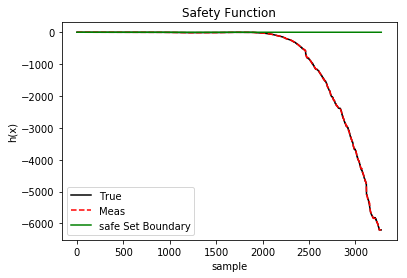

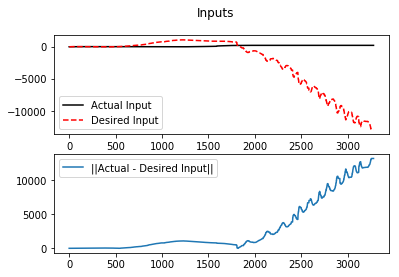

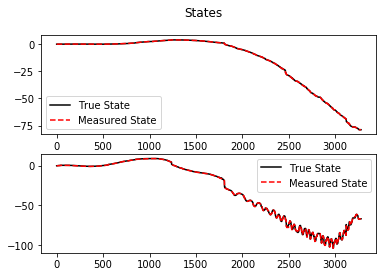

In [156]:
path = get_path("de14_noFilter")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()

In [ ]:
path = get_path("de14_noFilter")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()

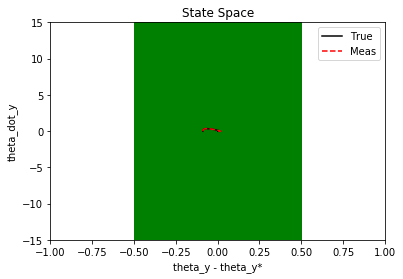

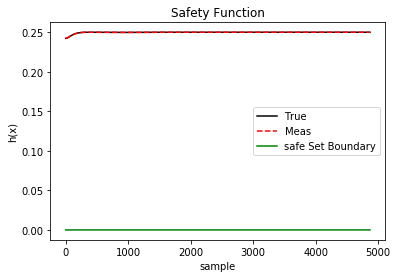

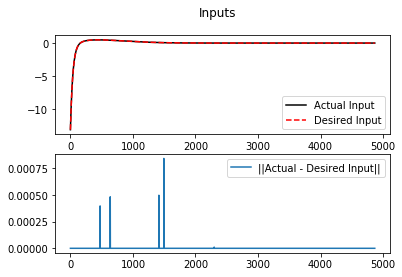

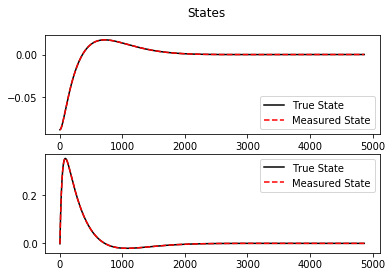

In [168]:
path = get_path("de_noNoise")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()


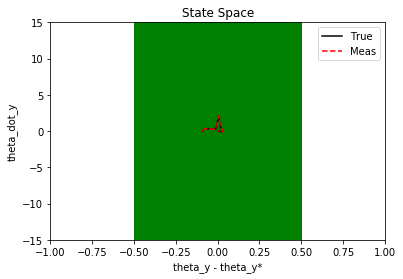

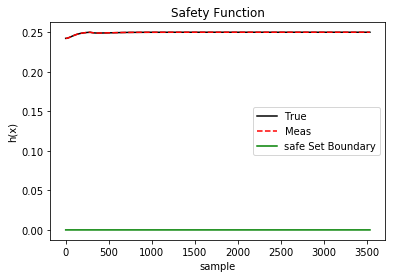

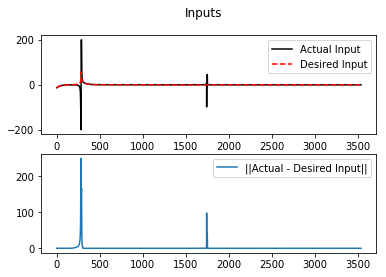

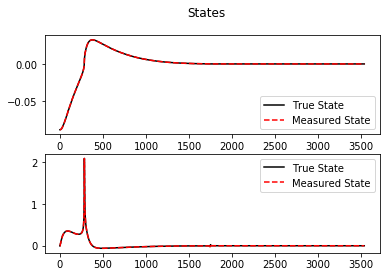

In [169]:
path = get_path("de_noNoiseFilter")
test = ecos_data_de(path, 1)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()

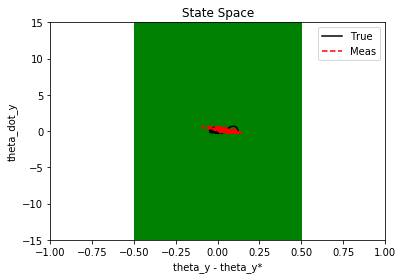

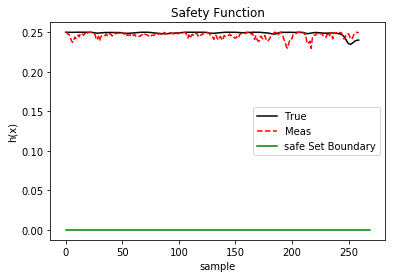

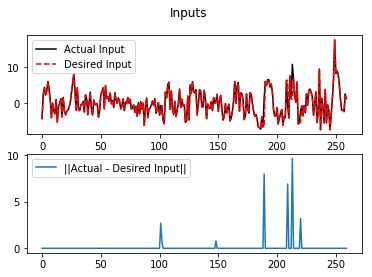

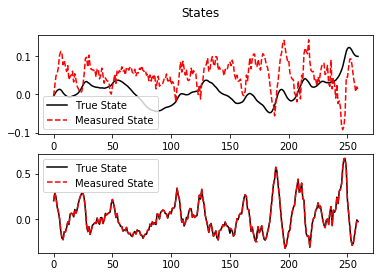

In [171]:
path = get_path("de_Learnin")
test = ecos_data_de(path, 10)
test.evaluate_safety(0.25)
test.plot_safety((-1,1),(-15, 15))
test.plot_inputs(200)
test.plot_states()

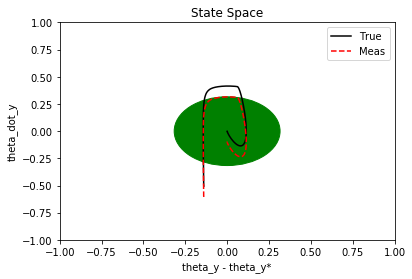

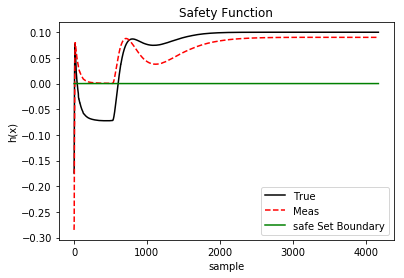

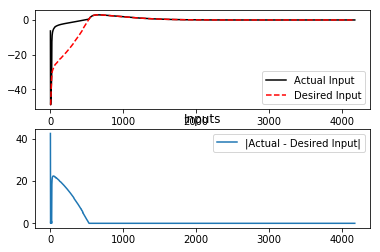

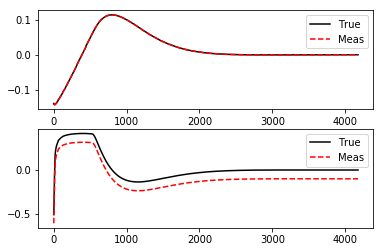

In [63]:
path = get_path("notRobust")
test = ecos_data(path)
test.evaluate_safety(0.1)
test.plot_contour((-1,1))
test.plot_inputs(200)
test.plot_states()


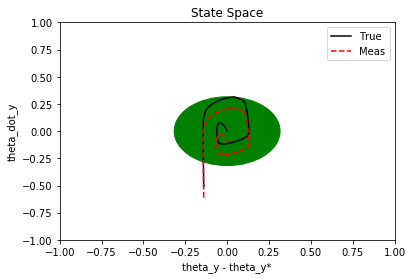

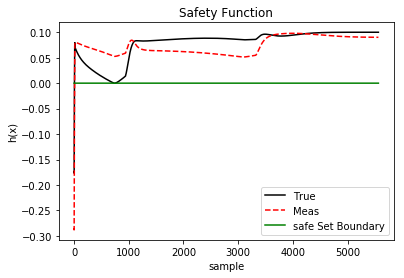

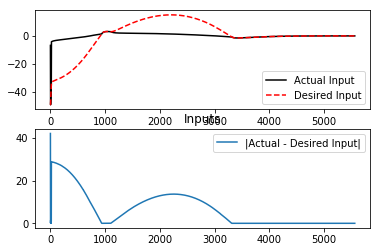

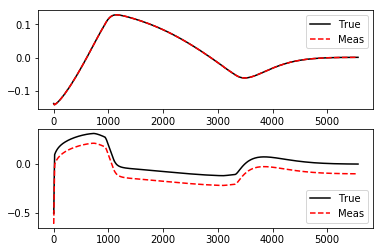

In [64]:
path = get_path("noiseNegX6")
test = ecos_data(path)
test.evaluate_safety(0.1)
test.plot_contour((-1,1))
test.plot_inputs(200)
test.plot_states()


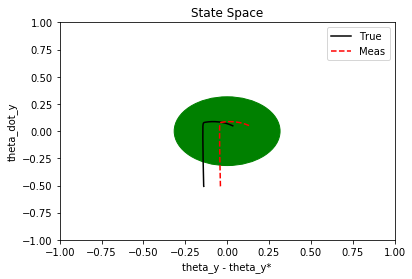

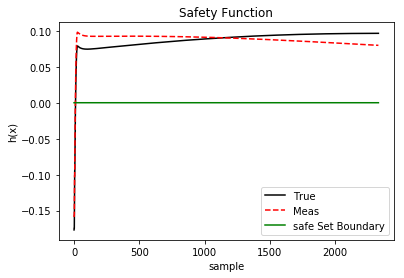

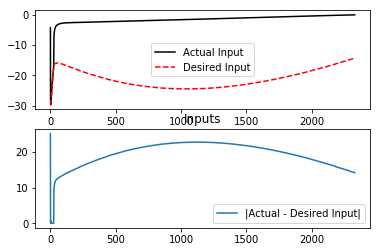

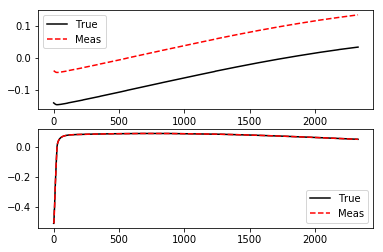

In [65]:
path = get_path("noiseX5")
test = ecos_data(path)
test.evaluate_safety(0.1)
test.plot_contour((-1,1))
test.plot_inputs(200)
test.plot_states()

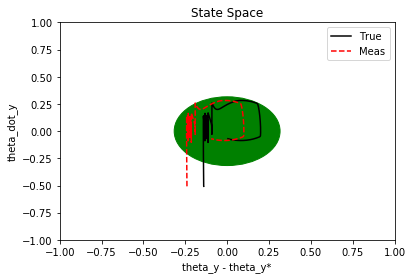

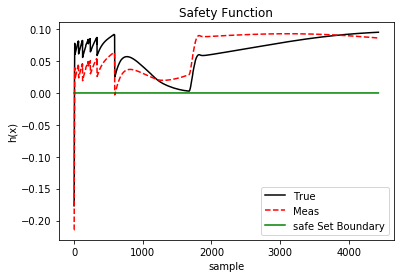

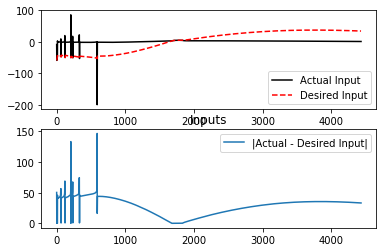

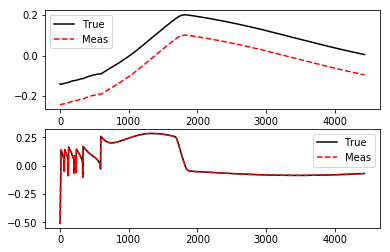

In [66]:
path = get_path("noiseNegX5") 
test = ecos_data(path)
test.evaluate_safety(0.1)
test.plot_contour((-1,1))
test.plot_inputs(200)
test.plot_states()

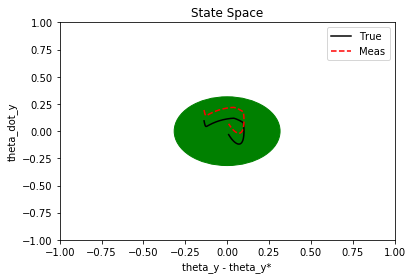

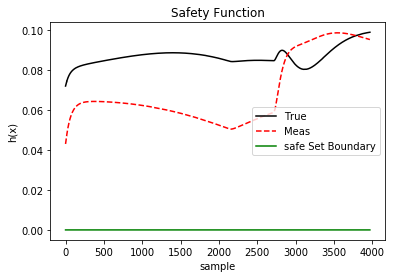

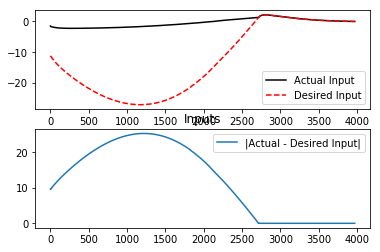

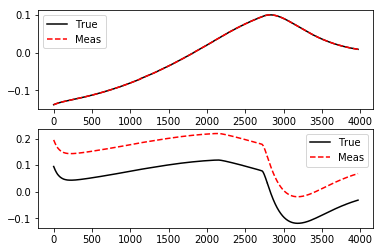

In [67]:
path = get_path("ic") 
test = ecos_data(path)
test.evaluate_safety(0.1)
test.plot_contour((-1,1))
test.plot_inputs(200)
test.plot_states()

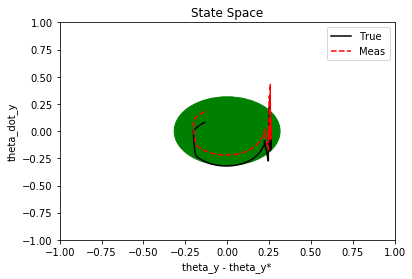

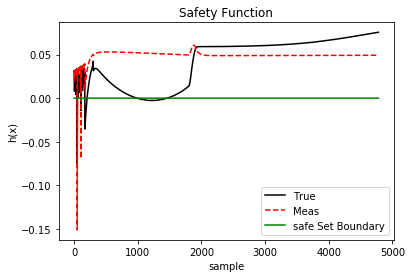

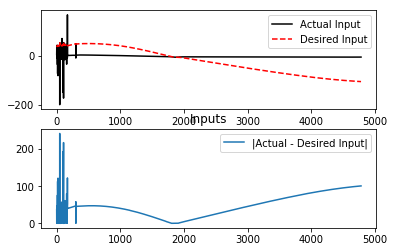

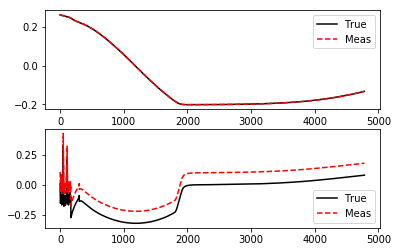

In [68]:
path = get_path("ic3") 
test = ecos_data(path)
test.evaluate_safety(0.1)
test.plot_contour((-1,1))
test.plot_inputs(200)
test.plot_states()

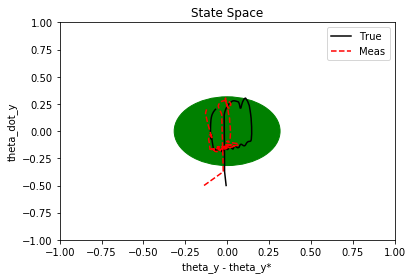

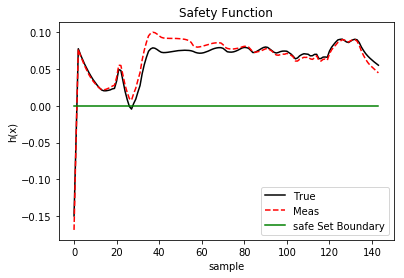

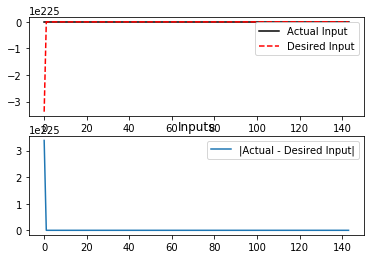

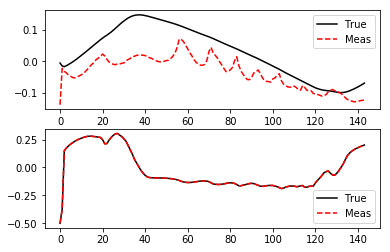

In [69]:
path = get_path("camera3")
test = ecos_data(path)
test.evaluate_safety(0.1)
test.plot_contour((-1,1))
test.plot_inputs(200)
test.plot_states()

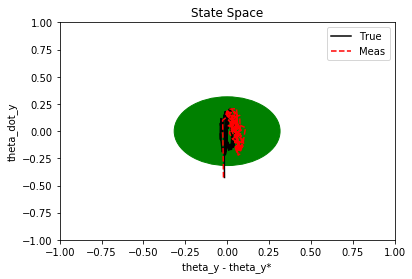

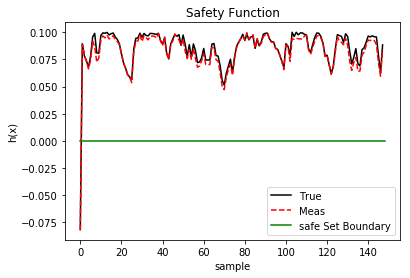

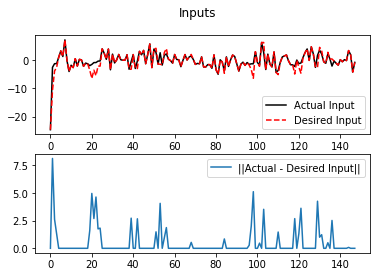

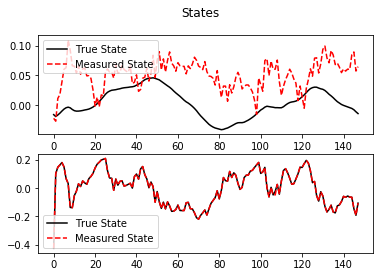

In [5]:
path = get_path("camera7")
test = ecos_data(path, 1)
test.evaluate_safety(0.1)
test.plot_contour((-1,1))
test.plot_inputs(200)
test.plot_states()

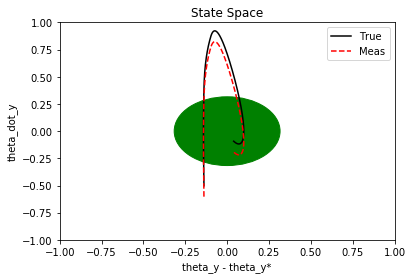

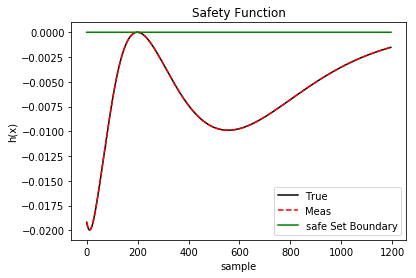

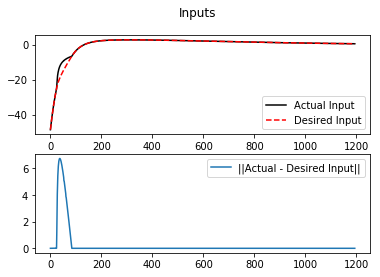

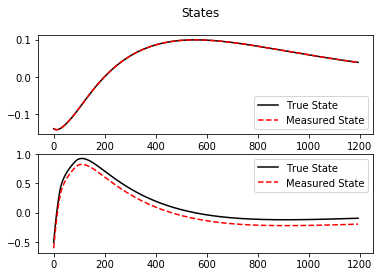

In [39]:
path = get_path("de")
test = ecos_data(path, 1)
test.evaluate_safety(0.1, dynamic_extension=True)
test.plot_contour((-1,1))
test.plot_inputs(200)
test.plot_states()

In [11]:
from math import tanh, cos, sin

model = [44.798,       #mb
	2.485,             #mw
	0.055936595310797, #Jw
	-0.02322718759275, #a2
	0.166845864363019, #c2
	3.604960049044268, #A2
	3.836289730154863, #B2
	1.069672194414735, #C2
	1.261650363363571, #K
	0.195,             #r
	0.5,               #L
	9.81,              #gGravity
	0.,                #FricCoeff 3.185188257847262
	1.0e-3,            #velEps
	1.225479467549329  #FricCoeff 1.225479467549329 
	]


def dynamics(X):

	f_drift = np.zeros((len(X),1))
	g_input_matrix = np.zeros((len(X),2))

	Fric = X[3] - X[6] * model[9]
	Fric = model[12] * tanh(Fric / model[13]) + model[14] * Fric
	a_tmp = cos(X[5])
	b_a_tmp = sin(X[5])
	f_drift[0] = X[3] * cos(X[2])
	f_drift[1] = X[3] * sin(X[2])
	f_drift[2] = X[4]
	f_tmp = model[3] * model[3]
	b_f_tmp = model[9] * model[9]
	c_f_tmp = model[4] * model[4]
	d_f_tmp = model[0] * model[0]
	e_f_tmp = 4.0 * f_tmp
	f_f_tmp = 4.0 * c_f_tmp
	g_f_tmp = X[4] * X[4]
	h_f_tmp = X[6] * X[6]
	i_f_tmp = 4.0 * h_f_tmp + 3.0 * g_f_tmp
	j_f_tmp = cos(2.0 * X[5])
	k_f_tmp = cos(3.0 * X[5])
	l_f_tmp = pow(model[3], 3.0)
	m_f_tmp = 4.0 * model[6] * model[4] * model[0]
	n_f_tmp = pow(model[4], 3.0)
	o_f_tmp = sin(2.0 * X[5])
	p_f_tmp = model[5] * model[4] * model[0] * model[9] * g_f_tmp
	q_f_tmp = -model[4] * model[7] * model[0] * model[9] * g_f_tmp
	r_f_tmp = sin(3.0 * X[5])
	s_f_tmp = 3.0 * f_tmp * model[4] * d_f_tmp * model[9] * g_f_tmp
	t_f_tmp = -4.0 * model[3] * model[4]
	u_f_tmp = 2.0 * model[3] * model[4]
	v_f_tmp = f_tmp * d_f_tmp
	f_tmp_tmp = v_f_tmp * b_f_tmp
	b_f_tmp_tmp = c_f_tmp * d_f_tmp * b_f_tmp
	f_f_tmp = 1.0 / ((((((((((4.0 * model[6] * model[2] + e_f_tmp * model[2] *
		model[0]) + f_f_tmp * model[2] * model[0]) + 2.0 * model[6] * model[0] *
	b_f_tmp) + f_tmp_tmp) + b_f_tmp_tmp) + 4.0 * model[6] * model[1] * b_f_tmp)
	+ e_f_tmp * model[0] * model[1] * b_f_tmp) + f_f_tmp *
	model[0] * model[1] * b_f_tmp) + (f_tmp + -c_f_tmp) *
	d_f_tmp * b_f_tmp * j_f_tmp) + u_f_tmp * d_f_tmp * b_f_tmp *
	o_f_tmp)
	w_f_tmp = 2.0 * f_tmp
	f_drift[3] = 0.5 * model[9] * f_f_tmp * (((((((((((((((((((((((-8.0 * model[6] *
		Fric + -8.0 * f_tmp * Fric * model[0]) + -8.0 * c_f_tmp * Fric * model[0]) +
	model[0] * model[9] * ((((-8.0 * model[4] * Fric + model[3] * (-model[5] +
		model[7]) * g_f_tmp) + 4.0 * model[3] * model[6] * (h_f_tmp + g_f_tmp)) +
	l_f_tmp * model[0] * i_f_tmp) + model[3] * c_f_tmp * model[0] * i_f_tmp) *
	a_tmp) + t_f_tmp * model[11] * d_f_tmp * model[9] * j_f_tmp) + model[3] *
	model[5] * model[0] * model[9] * g_f_tmp * k_f_tmp) + -model[3] * model[7] *
	model[0] * model[9] * g_f_tmp * k_f_tmp) + l_f_tmp * d_f_tmp * model[9] *
	g_f_tmp * k_f_tmp) + -3.0 * model[3] * c_f_tmp * d_f_tmp * model[9] *
	g_f_tmp * k_f_tmp) + 8.0 * model[3] * Fric * model[0] * model[9] * b_a_tmp)
	+ m_f_tmp * h_f_tmp * model[9] * b_a_tmp) + e_f_tmp * model[4] * d_f_tmp *
	h_f_tmp * model[9] * b_a_tmp) + 4.0 * n_f_tmp * d_f_tmp * h_f_tmp * model[9]
	* b_a_tmp) + p_f_tmp * b_a_tmp) + m_f_tmp * model[9] * g_f_tmp * b_a_tmp) +
	q_f_tmp * b_a_tmp) + s_f_tmp * b_a_tmp) + 3.0 * n_f_tmp * d_f_tmp * model[9]
	* g_f_tmp * b_a_tmp) + w_f_tmp * model[11] * d_f_tmp * model[9] * o_f_tmp) +
	-2.0 * c_f_tmp * model[11] * d_f_tmp * model[9] * o_f_tmp) + p_f_tmp *
	r_f_tmp) + q_f_tmp * r_f_tmp) + s_f_tmp * r_f_tmp) + -n_f_tmp * d_f_tmp *
	model[9] * g_f_tmp * r_f_tmp)
	e_f_tmp = model[10] * model[10]
	i_f_tmp = -2.0 * f_tmp
	k_f_tmp = 2.0 * c_f_tmp
	l_f_tmp = i_f_tmp * model[0]
	m_f_tmp = k_f_tmp * model[0]
	n_f_tmp = f_tmp * model[0]
	c_f_tmp *= model[0]
	p_f_tmp = model[4] * model[0]
	q_f_tmp = model[2] * e_f_tmp
	e_f_tmp *= model[1]
	r_f_tmp = 2.0 * (model[7] + n_f_tmp)
	s_f_tmp = 2.0 * (model[5] + c_f_tmp)
	u_f_tmp *= model[0]
	f_drift[4] = b_f_tmp * X[4] * ((-2.0 * model[3] * model[0] * X[3] * a_tmp + t_f_tmp *
			model[0] * X[6] * j_f_tmp) + -2.0 * (p_f_tmp * X[3] + (((model[5] + -model[7])
			+ l_f_tmp) + m_f_tmp) * X[6] * a_tmp) * b_a_tmp) * (1.0 / ((((q_f_tmp +
			e_f_tmp * b_f_tmp) + r_f_tmp * b_f_tmp * (a_tmp * a_tmp)) + s_f_tmp *
			b_f_tmp * (b_a_tmp * b_a_tmp)) + u_f_tmp * b_f_tmp * o_f_tmp))
	f_drift[5] = X[6]
	t_f_tmp = 4.0 * model[4] * model[11]
	k_f_tmp = k_f_tmp * model[2] * model[0]
	m_f_tmp = m_f_tmp * model[1] * b_f_tmp
	x_f_tmp = -(model[4] * model[4]) * d_f_tmp
	f_drift[6] = f_f_tmp * ((((((((((((((((((((8.0 * Fric * model[2] + 4.0 * Fric *
			model[0] * b_f_tmp) + 8.0 * Fric * model[1] * b_f_tmp) + 2.0 * model[0] *
			(2.0 * model[4] * Fric * model[9] + model[3] * model[11] * (2.0 * model[2] +
			(model[0] + 2.0 * model[1]) * b_f_tmp)) * a_tmp) + -2.0 * model[3] * model[4]
			* model[0] * (model[0] * h_f_tmp * b_f_tmp + -2.0 * (model[2] + model[1] *
			b_f_tmp) * g_f_tmp) * j_f_tmp) + t_f_tmp * model[2] * model[0] * b_a_tmp) +
			-4.0 * model[3] * Fric * model[0] * model[9] * b_a_tmp) + 2.0 * model[4] *
			model[11] * d_f_tmp * b_f_tmp * b_a_tmp) + t_f_tmp * model[0] * model[1] *
			b_f_tmp * b_a_tmp) + v_f_tmp * h_f_tmp * b_f_tmp * o_f_tmp) + x_f_tmp *
			h_f_tmp * b_f_tmp * o_f_tmp) + -2.0 * model[5] * model[2] * g_f_tmp *
			o_f_tmp) + 2.0 * model[7] * model[2] * g_f_tmp * o_f_tmp) + i_f_tmp * model
			[2] * model[0] * g_f_tmp * o_f_tmp) + k_f_tmp * g_f_tmp * o_f_tmp) + -model
			[5] * model[0] * b_f_tmp * g_f_tmp * o_f_tmp) + model[7] * model[0] *
			b_f_tmp * g_f_tmp * o_f_tmp) + -2.0 * model[5] * model[1]
			* b_f_tmp * g_f_tmp * o_f_tmp) + 2.0 * model[7] * model[1]
			* b_f_tmp * g_f_tmp * o_f_tmp) + l_f_tmp * model[1] *
			b_f_tmp * g_f_tmp * o_f_tmp) + m_f_tmp * g_f_tmp * o_f_tmp)
	t_f_tmp = x_f_tmp * b_f_tmp
	l_f_tmp = (((((((2.0 * model[6] * model[2] + w_f_tmp * model[2] * model[0]) +
			k_f_tmp) + model[6] * model[0] * b_f_tmp) + f_tmp_tmp) +
			b_f_tmp_tmp) + 2.0 * model[6] * model[1] * b_f_tmp) + w_f_tmp *
			model[0] * model[1] * b_f_tmp) + m_f_tmp
	j_f_tmp = -f_tmp * d_f_tmp * b_f_tmp
	i_f_tmp = model[3] * model[4] * d_f_tmp * b_f_tmp * o_f_tmp
	g_f_tmp = p_f_tmp * model[9] * a_tmp
	h_f_tmp = -model[3] * model[0] * model[9] * b_a_tmp
	
	Fric = model[8] * model[9] * ((((model[6] + n_f_tmp) + c_f_tmp) + g_f_tmp) +
			h_f_tmp)
	g_input_matrix[3,0] = Fric * (1.0 / (((l_f_tmp + t_f_tmp * (a_tmp * a_tmp)) + j_f_tmp *
			(b_a_tmp * b_a_tmp)) + i_f_tmp))
	g_input_matrix[3,1] = Fric * (1.0 / (((l_f_tmp + t_f_tmp * (a_tmp * a_tmp)) + j_f_tmp *
			(b_a_tmp * b_a_tmp)) + i_f_tmp))
	t_f_tmp = r_f_tmp * model[9]
	l_f_tmp = q_f_tmp * (1.0 / model[9]) + e_f_tmp * model[9]
	j_f_tmp = s_f_tmp * model[9]
	i_f_tmp = u_f_tmp * model[9] * o_f_tmp
	g_input_matrix[4,0] = -model[8] * model[10] * (1.0 / (((l_f_tmp + t_f_tmp * (a_tmp * a_tmp))
			+ j_f_tmp * (b_a_tmp * b_a_tmp)) + i_f_tmp))
	g_input_matrix[4,1] = model[8] * model[10] * (1.0 / (((l_f_tmp + t_f_tmp * (a_tmp * a_tmp))
			+ j_f_tmp * (b_a_tmp * b_a_tmp)) + i_f_tmp))
	g_input_matrix[0,0] = 0.0
	g_input_matrix[1,0] = 0.0
	g_input_matrix[2,0] = 0.0
	g_input_matrix[5,0] = 0.0
	g_input_matrix[0,1] = 0.0
	g_input_matrix[1,1] = 0.0
	g_input_matrix[2,1] = 0.0
	g_input_matrix[5,1] = 0.0
	t_f_tmp = -2.0 * model[8] * ((((2.0 * model[2] + model[0] * b_f_tmp) + 2.0 *
	model[1] * b_f_tmp) + g_f_tmp) + h_f_tmp) * f_f_tmp
	g_input_matrix[6,0] = t_f_tmp
	g_input_matrix[6,1] = t_f_tmp

	return f_drift, g_input_matrix

		



In [12]:

def dynamics_to_integrate(X,t): 
    f , g = dynamics(X)
    xdot = f + np.matmul(g,np.matrix(output['x'][2:4]).transpose())
    xdot = np.array(xdot).squeeze()
    return xdot 

traj = odeint(dynamics_to_integrate, xCurrent, np.linspace(0,0.005, 10))

for x in traj: 
    print(-1/2*((x[5]-x5_eq)**2 + x[6]**2) + 0.1)

NameError: global name 'output' is not defined

In [13]:
xCurrent = [-0.0001, -0.0000, 0.0000, -0.0204, 0.0000, -0.0077, -0.9575] 

feas_chart = []

L_lgh = 0.5
L_lfh = 0.1
alpha = 10
L_ah  = 5
epsilon =0.1
x5_eq = 0.138


for xdot in np.linspace(-1, 1, 21):
    for theta_y in np.linspace(-0.5+x5_eq, 0.5+x5_eq, 41):
        for thetadot_y in np.linspace(-0.5, 0.5, 41):
            xCurrent = [0.0, 0.0, 0.0, xdot, 0.0, theta_y, thetadot_y] 

            f,g = dynamics(xCurrent)
            # h = -(1/2)*(x[5]- x5_eq)^2 - (1/2)*x[6]^2 + C 
            # Safe Set: x[5]^2 + x[6]^2 <= 2*C 
            # Lfh(x) = -x[6]*x[5] - x[6]*f[6]  
            # Lgh(x) = -x[6]*g[6,[0,1]]
            Lfh = -xCurrent[6]*(xCurrent[5] - x5_eq + f[6])
            Lgh = -xCurrent[6]*g[6,[0,1]]  
            csf = -1/2*((xCurrent[5]-x5_eq)**2 + xCurrent[6]**2) + 0.1
            G  = [[-1/np.sqrt(2), 0, 0, 0], [-1/np.sqrt(2), 0, 0, 0 ], [0, 0, -1, 0], [0, 0, 0, -1], [0, 0, -Lgh[0],  -Lgh[1]],[0, 0, -epsilon*L_lgh, 0], [0, 0, 0, -epsilon*L_lgh]]
            G  = sp.sparse.csc_matrix(G)
            h  = np.array([1/np.sqrt(2), -1/np.sqrt(2), 0, 0, Lfh[0] + alpha*(csf) - (L_lfh + L_ah)*epsilon, 0, 0 ])
            cost = np.array([1.0, 0.0, 0.0, 0.0]) #-self.inputDes_.inputVec[0],  -self.inputDes_.inputVec[1]])


            dims = {
                'l': 0,
                'q': [4,3],
                'e': 0
            }

            output = ecos.solve(cost,G,h,dims, verbose=False)

            feas_chart.append([xdot, theta_y-x5_eq, thetadot_y, output["info"]["exitFlag"]])
    print xdot




-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.3999999999999999
-0.29999999999999993
-0.19999999999999996
-0.09999999999999998
0.0
0.10000000000000009
0.20000000000000018
0.30000000000000004
0.40000000000000013
0.5
0.6000000000000001
0.7000000000000002
0.8
0.9000000000000001
1.0


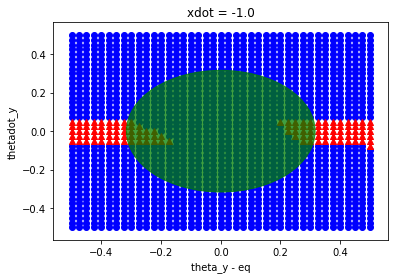

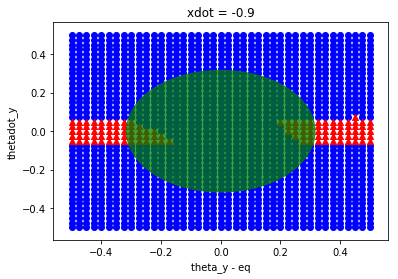

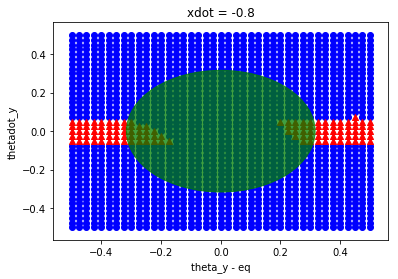

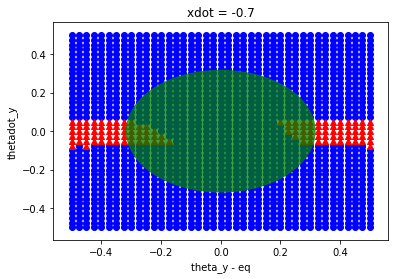

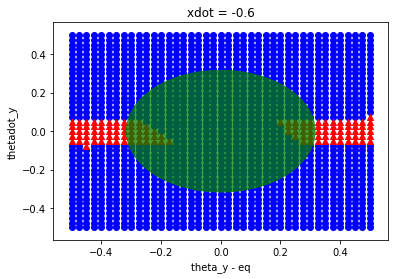

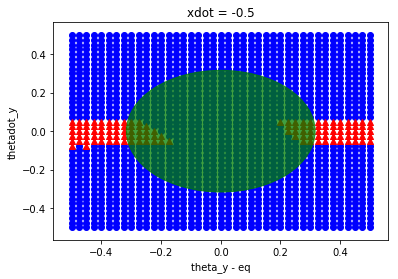

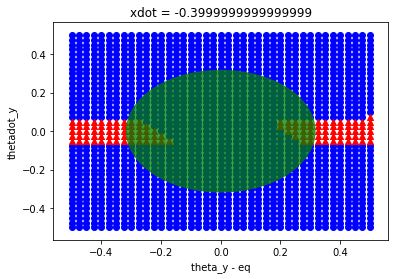

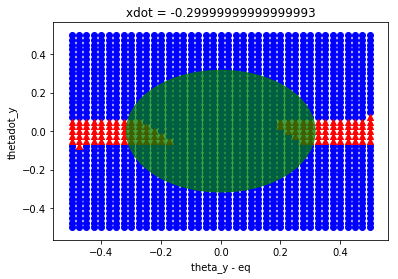

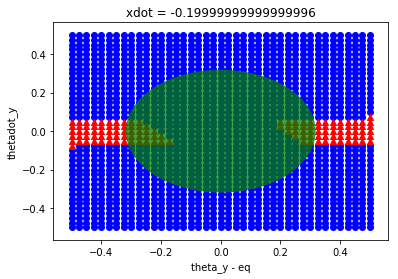

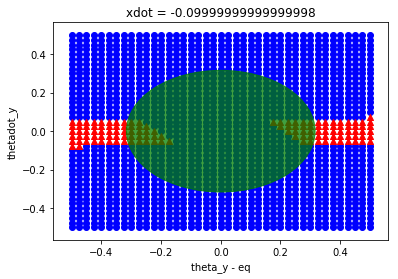

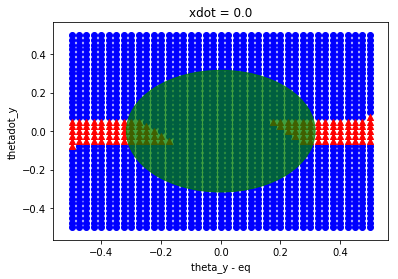

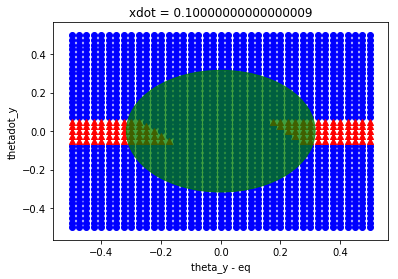

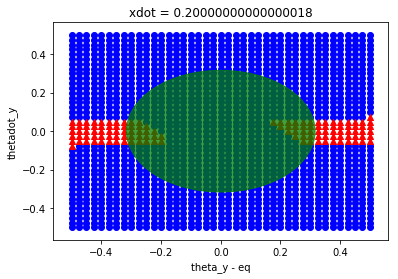

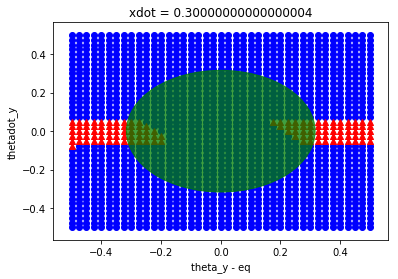

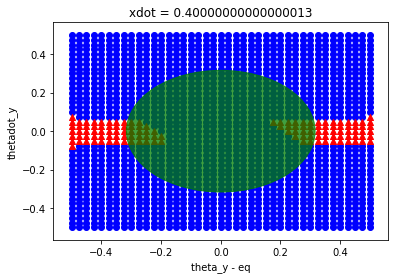

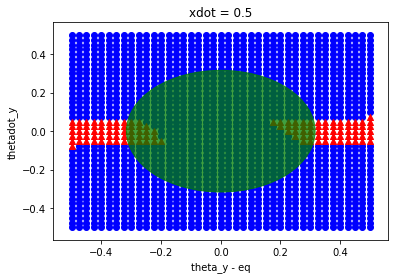

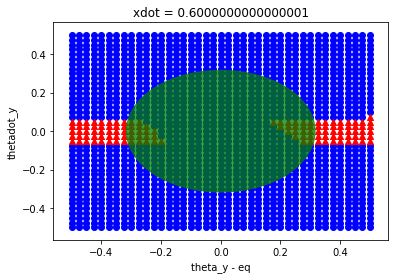

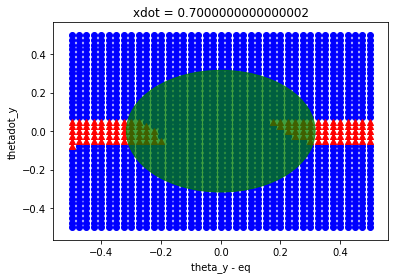

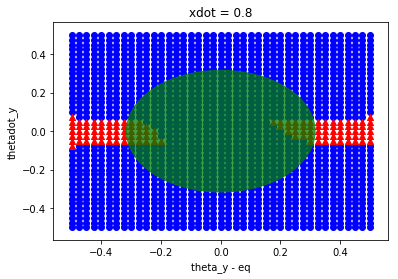

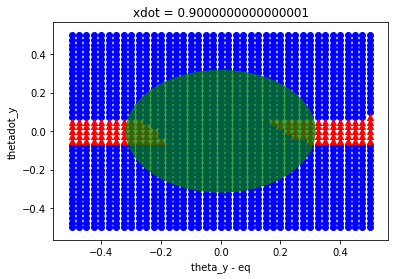

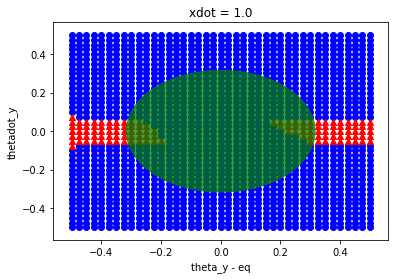

In [14]:
#for xdot in np.linspace(-10, 10, 20):
for xdot in np.linspace(-1, 1, 21):
    points_feas = np.array([p for p in feas_chart if xdot == p[0] and (p[3] == 0 or p[3] ==10) ])
    points_infeas = np.array([p for p in feas_chart if xdot == p[0] and (p[3] != 0 and p[3] !=10)])

    fig = plt.figure()
    ax = fig.gca()
    safeSet = plt.Circle((0, 0), np.sqrt(0.1), color='g', alpha=0.75)
    ax.add_artist(safeSet)
    if not points_feas.size==0 :
        ax.scatter(points_feas[:,1], points_feas[:,2], c='b', marker='o')
    if not points_infeas.size==0 :
        ax.scatter(points_infeas[:,1], points_infeas[:,2], c='r', marker='^')
    plt.xlabel("theta_y - eq")
    plt.ylabel("thetadot_y")
    plt.title("xdot = "+ str(xdot))
    plt.show()

In [49]:
# Dynamic Extension Version 

xCurrent = [-0.0001, -0.0000, 0.0000, -0.0204, 0.0000, -0.0077, -0.9575] 

feas_chart = []

L_lgh = 0.5
L_lfh = 1
alpha = 10
alpha_e = 1 
L_ah  = 1
epsilon =0.1
x5_eq = 0.138
C = 0.04

for xdot in np.linspace(-1, 1, 21):
    for theta_y in np.linspace(-0.5+x5_eq, 0.5+x5_eq, 41):
        for thetadot_y in np.linspace(-0.5, 0.5, 41):
            xCurrent = [0.0, 0.0, 0.0, xdot, 0.0, theta_y, thetadot_y] 

            f,g = dynamics(xCurrent)

            Lfh = -2*(xCurrent[6]**2 + alpha*(xCurrent[5]-0.138)*xCurrent[6] + (xCurrent[5]-0.138)*f[6])
            Lgh = -2*(xCurrent[5]-0.138)*g[6,[0,1]]  
            csf = -2*(xCurrent[5]-0.138)*xCurrent[6]+alpha*(C - (xCurrent[5]-0.138)**2)
            G  = [[-1/np.sqrt(2), 0, 0, 0], [-1/np.sqrt(2), 0, 0, 0 ], [0, 0, -1, 0], [0, 0, 0, -1], [0, 0, -Lgh[0],  -Lgh[1]],[0, 0, -epsilon*L_lgh, 0], [0, 0, 0, -epsilon*L_lgh]]
            G  = sp.sparse.csc_matrix(G)
            h  = np.array([1/np.sqrt(2), -1/np.sqrt(2), 0, 0, Lfh[0] + alpha_e*(csf) - (L_lfh + L_ah)*epsilon, 0, 0 ])
            cost = np.array([1.0, 0.0, 0.0, 0.0]) #-self.inputDes_.inputVec[0],  -self.inputDes_.inputVec[1]])


            dims = {
                'l': 0,
                'q': [4,3],
                'e': 0
            }

            output = ecos.solve(cost,G,h,dims, verbose=False)

            feas_chart.append([xdot, theta_y-x5_eq, thetadot_y, output["info"]["exitFlag"]])
    print xdot




-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.3999999999999999
-0.29999999999999993
-0.19999999999999996
-0.09999999999999998
0.0
0.10000000000000009
0.20000000000000018
0.30000000000000004
0.40000000000000013
0.5
0.6000000000000001
0.7000000000000002
0.8
0.9000000000000001
1.0


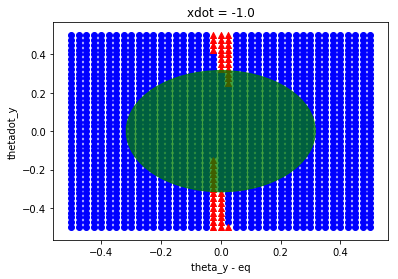

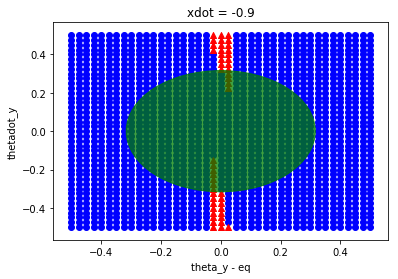

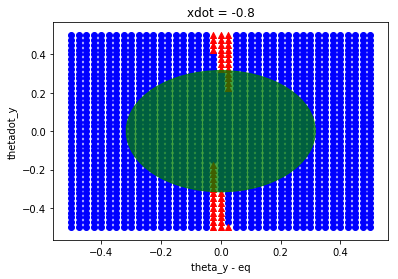

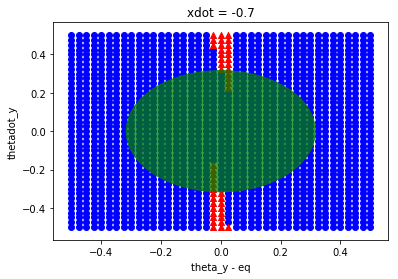

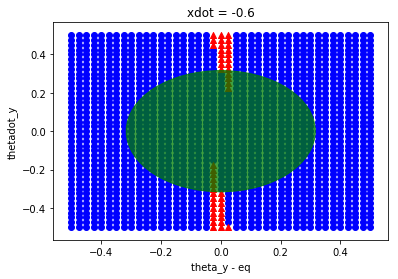

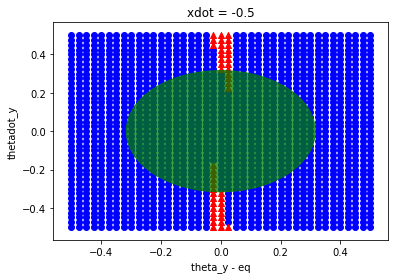

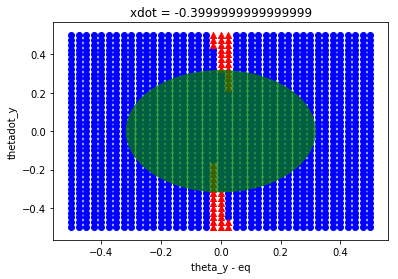

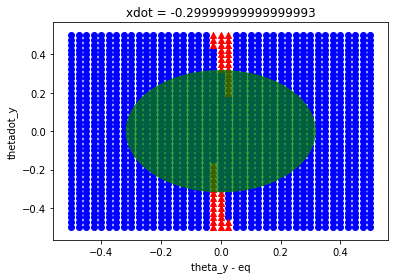

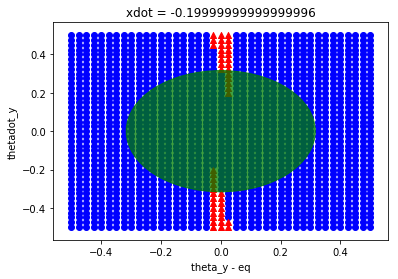

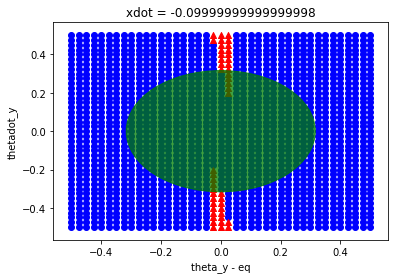

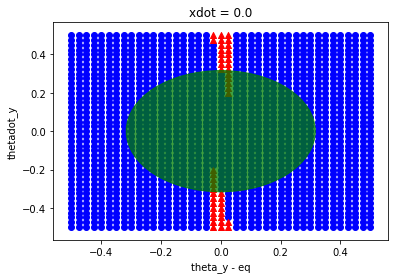

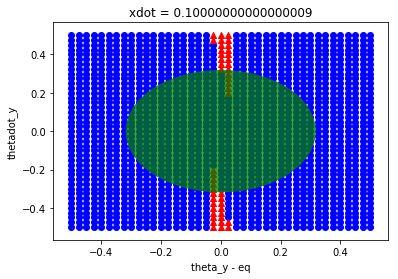

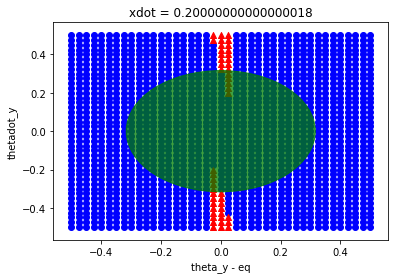

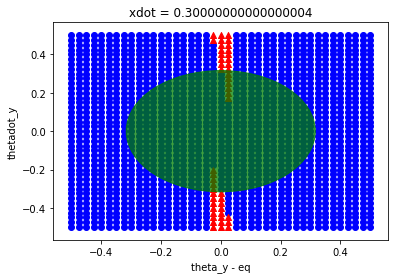

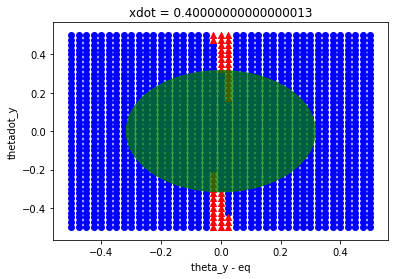

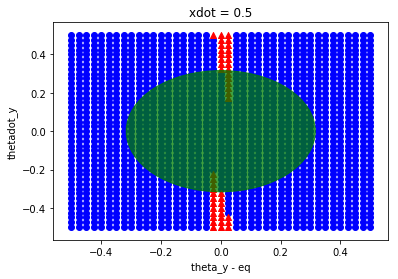

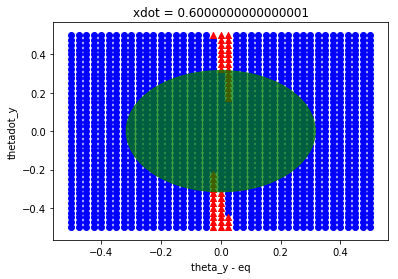

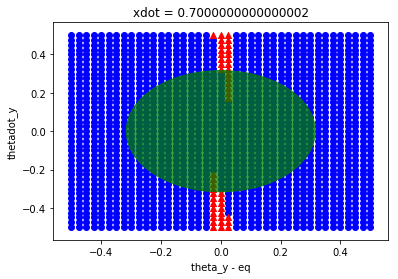

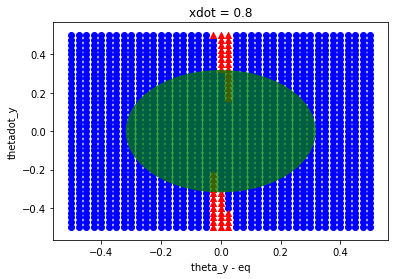

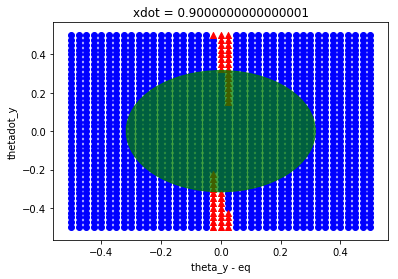

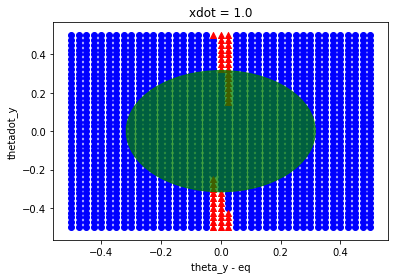

In [50]:
#for xdot in np.linspace(-10, 10, 20):
for xdot in np.linspace(-1, 1, 21):
    points_feas = np.array([p for p in feas_chart if xdot == p[0] and (p[3] == 0 or p[3] ==10) ])
    points_infeas = np.array([p for p in feas_chart if xdot == p[0] and (p[3] != 0 and p[3] !=10)])

    fig = plt.figure()
    ax = fig.gca()
    safeSet = plt.Circle((0, 0), np.sqrt(0.1), color='g', alpha=0.75)
    ax.add_artist(safeSet)
    if not points_feas.size==0 :
        ax.scatter(points_feas[:,1], points_feas[:,2], c='b', marker='o')
    if not points_infeas.size==0 :
        ax.scatter(points_infeas[:,1], points_infeas[:,2], c='r', marker='^')
    plt.xlabel("theta_y - eq")
    plt.ylabel("thetadot_y")
    plt.title("xdot = "+ str(xdot))
    plt.show()

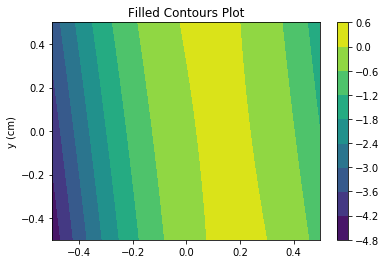

In [44]:
import numpy as np
import matplotlib.pyplot as plt
xlist = np.linspace(-0.5, 0.5, 100)
ylist = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = -2*(X-0.138)*Y+alpha*(0.01 - (X-0.138)**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()